# Funções

In [1]:
import time

#-----------------------------------------------------------------------------------
#  Função que plota o CAPPI das variáveis polarimétricas Z, ZDR, KDP, COR e VEL
#-----------------------------------------------------------------------------------
def quicklook_cappi_z_zdr_kdp_cor_vel(fileout, ds, ano, mes, dia, hor, min, seg):

    # importa bibliotecas
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs  

    # define o tamanho da figura
    fig = plt.figure(figsize=(9,9))

    # subtítulo da figura
    plt.suptitle(f'CAPPI 3000m - LONTRAS: {ano}-{mes}-{dia} at {hor}:{min}:{seg} UTC')

    # Z
    ax1 = plt.subplot(321)
    ds['reflectivity_horizontal'][:,:].plot(cmap='pyart_NWSRef', vmin=0, vmax=70, ax=ax1)
    plt.title('ZH')

    # ZDR
    ax2 = plt.subplot(322)
    ds['differential_reflectivity'][:,:].plot(cmap='coolwarm', vmin=-2, vmax=6, ax=ax2)
    plt.title('ZDR')
    
    # KDP
    ax3 = plt.subplot(323)
    ds['specific_differential_phase'][:,:].plot(cmap='coolwarm', vmin=-2, vmax=6, ax=ax3)
    plt.title('KDP')
    
    # COR
    ax4 = plt.subplot(324)
    ds['cross_correlation_ratio'][:,:].plot(cmap='jet', vmin=0.7, vmax=1.0, ax=ax4)
    plt.title('RhoHV')

    # VEL
    ax5 = plt.subplot(325)
    ds['velocity_horizontal'][:,:].plot(cmap='coolwarm', vmin=-20, vmax=20, ax=ax5)
    plt.title('VEL')

    # recorta figura
    plt.tight_layout()

    # salva figura
    plt.savefig(fileout, dpi=300)
    print('...... 6. Plotou quicklook das variáveis polarimétricas')

#-----------------------------------------------------------------------------------
#                   Função que plota o CAPPI da precipitação
#-----------------------------------------------------------------------------------
def quicklook_cappi_rainrate(fileout, ds, ano, mes, dia, hor, min, seg):

    # importa bibliotecas
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs  

    # define o tamanho da figura
    fig = plt.figure(figsize=(11,11))

    # subtítulo da figura
    plt.suptitle(f'CAPPI 3000m - LONTRAS: {ano}-{mes}-{dia} at {hor}:{min}:{seg} UTC')

    # Z
    ax1 = plt.subplot(321)
    ds['rainrate_z'][:,:].plot(cmap='pyart_LangRainbow12', vmin=1, vmax=50, ax=ax1)
    plt.title('rainrate_z')

    # KDP
    ax2 = plt.subplot(322)
    ds['rainrate_kdp'][:,:].plot(cmap='pyart_LangRainbow12', vmin=1, vmax=50, ax=ax2)
    plt.title('rainrate_kdp')

    # Z-KDP
    ax3 = plt.subplot(323)
    ds['rainrate_z_kdp'][:,:].plot(cmap='pyart_LangRainbow12', vmin=1, vmax=50, ax=ax3)
    plt.title('rainrate_z_kdp')

    # Z-ZDR-KDP
    ax4 = plt.subplot(324)
    ds['rainrate_z_zdr_kdp'][:,:].plot(cmap='pyart_LangRainbow12', vmin=1, vmax=50, ax=ax4)
    plt.title('rainrate_z_zdr_kdp')

    # Z-ZDR-KDP com filtro para KDP
    ax4 = plt.subplot(325)
    ds['rainrate_z_zdr_kdp_filtrokdp'][:,:].plot(cmap='pyart_LangRainbow12', vmin=1, vmax=50, ax=ax4)
    plt.title('rainrate_z_zdr_kdp_filtrokdp')

    # recorta figura
    plt.tight_layout()

    # salva figura
    plt.savefig(fileout, dpi=300)
    print('...... 7. Plotou quicklook da precipitação \n')

#-----------------------------------------------------------------------------------
#  Função que plota circulos de distância em geral
#-----------------------------------------------------------------------------------
def evm_plota_aneis_em_geral(aneis, lon_r, lat_r, color, label):

    """
    Retorna círculos de distância centrado no radar

    Parâmetros de entrada:
                           aneis (lista): tamanho do raio do círculo em km
                           lon_r (float): valor da longitude do centro do círculo em graus
                           lat_r (float): valor da latitude do centro do círculo em graus
                           color (str): cor do raio do círculo
                           label (str): legenda

    Parâmetros de saída:
                         latitude e longitude que delimitam os círculos de distância centrado no radar e plota os círculos

    Exemplo:
             evm_plota_aneis_em_geral([100], -45.97279, -23.600795, 'gray', label='Radar: 100 km')
    """

    import geopy                              # Biblioteca para geocodificação
    from geopy import distance                # Função para calculo de distância
    import numpy as np

    origin = geopy.Point(lat_r, lon_r)

    lons = np.zeros((len(aneis), 361))
    lats = np.zeros((len(aneis), 361))
    for i, dis in enumerate(aneis):
        xpts = []
        ypts = []
        for az in range(361):
            destination = distance.distance(kilometers=dis).destination(origin, az)
            lat2, lon2 = destination.latitude, destination.longitude
            xpts.append(lon2)
            ypts.append(lat2)
        lons[i,:] = xpts[:]
        lats[i,:] = ypts[:]

    for i, anel in enumerate(aneis):
        ax.plot(lons[i,:], lats[i,:], color=color, label= label)

# Processamento

- Existem diversas relações para calcular a precipitação [mm/h] através das variáveis polarimétricas fornecidas pelo radar. Usaremos como exemplo três equações fornecidas pelo [Py-ART](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.html) e uma proveniente de [Ryzhkov et al (2005)](https://journals.ametsoc.org/view/journals/apme/44/4/jam2213.1.xml):

*  1. [retrieve.est_rain_rate_z](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.est_rain_rate_z.html): estima a precipitação através de Lei de potência com a refletividade (Z-R)
*  2. [retrieve.est_rain_rate_kdp](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.est_rain_rate_kdp.html): estima a precipitação através da Lei de potência com o KDP (Z-KDP)
*  3. [retrieve.est_rain_rate_zkdp](https://arm-doe.github.io/pyart-docs-travis/API/generated/pyart.retrieve.est_rain_rate_zkdp.html): estima a precipitação através da combinação da Lei de potência com a chuva-KDP (Z-KDP) e chuva-refletividade (Z-R)
*  4. Calcula a precipitação utilizando uma relação Z-ZDR-KDP para radar Banda-S desenvolvida por [Ryzhkov et al (2005)](https://journals.ametsoc.org/view/journals/apme/44/4/jam2213.1.xml). Nessa formulação usa-se Z, ZDR e KDP para estimar a precipitação
*   5. Calcula a precipitação utilizando uma relação Z-ZDR-KDP para radar Banda-S desenvolvida por [Ryzhkov et al (2005)](https://journals.ametsoc.org/view/journals/apme/44/4/jam2213.1.xml), substituindo onde não tem valor válido de KDP, usa-se a precipitação calculada pela Relação de Marshall-Palmer

In [2]:
import glob
files = sorted(glob.glob('input/2023-03-23/R13227490_202303231840.hdf')) # PNOVA2-20230218000002.HDF5
files

['input/2023-03-23/R13227490_202303231840.hdf']

In [ ]:
import pyart
import pandas as pd
radar = pyart.aux_io.read_odim_h5('input/2023-03-23/R13227490_202303231840.hdf')   
print(pd.DataFrame(list(radar.fields)))


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

PROCESSANDO ===>> input/2023-03-23/R13227490_202303231840.hdf
...... 1. Extraiu informações da data
...... 2. Calculou campo de taxa de precipitação
...... 3. Gerou CAPPI
...... 4. Transformou para DataSet
...... 5. Salvou arquivo NETCDF
...... 6. Plotou quicklook das variáveis polarimétricas
...... 7. Plotou quicklook da precipitação 

CPU times: total: 11.8 s
Wall time: 23 s


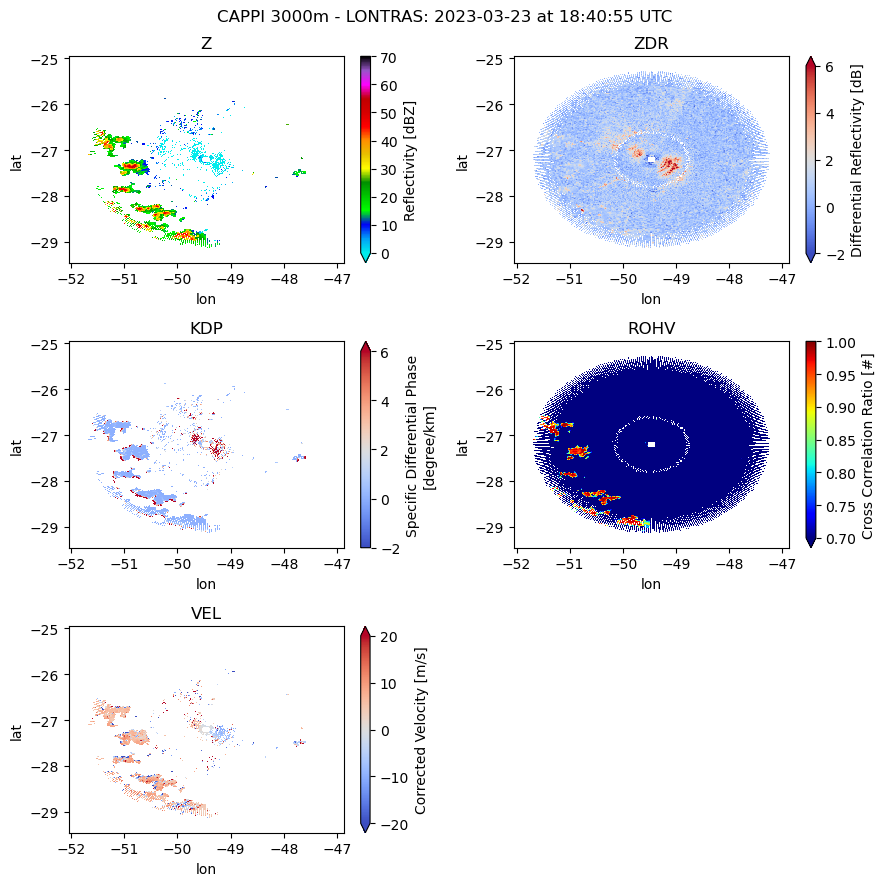

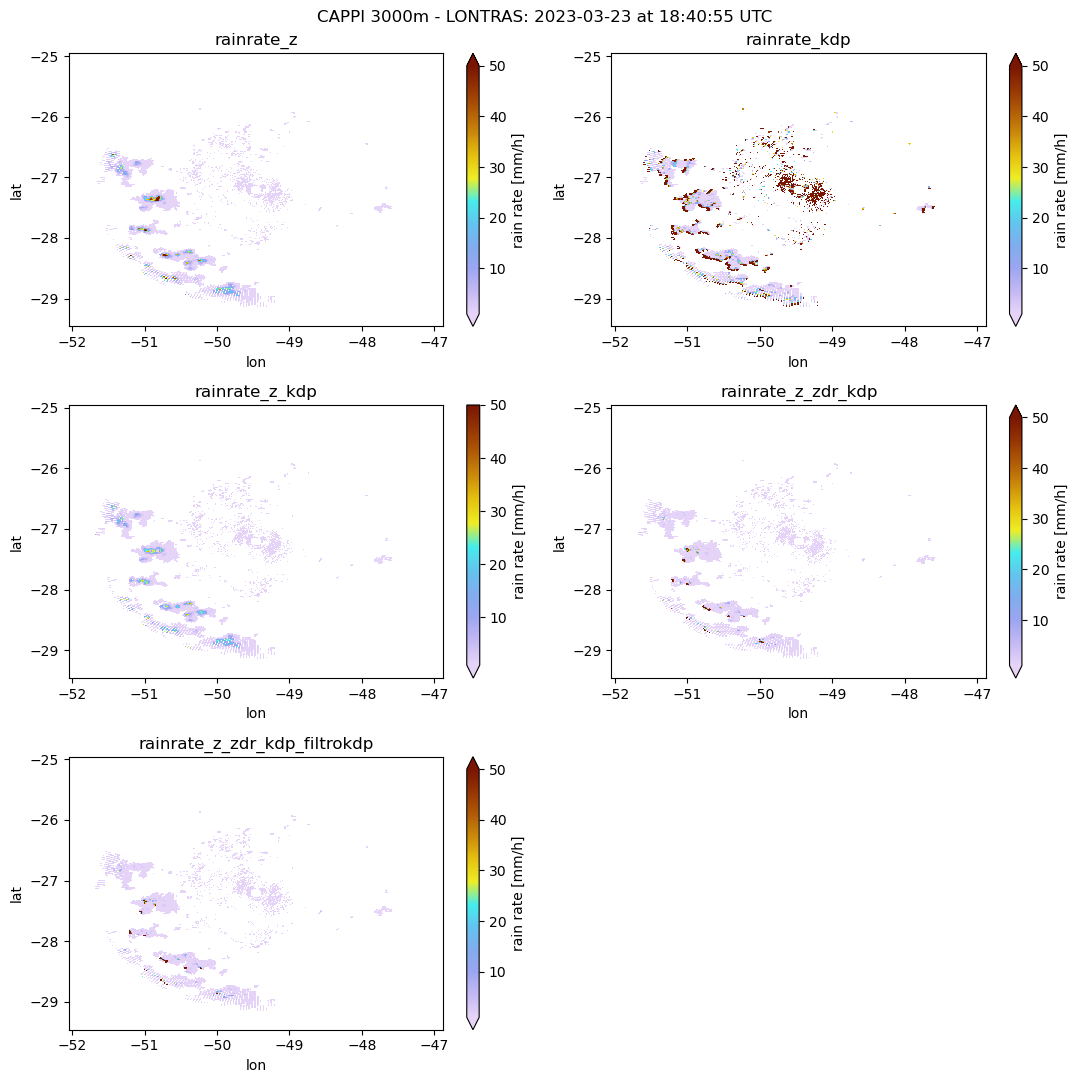

In [3]:
%%time
# Tempo de processamento: 23s para gerar um arquivo de CAPPI
#========================================================================================================================#
#                                              IMPORTAÇÃO DAS BIBLIOTECAS
#========================================================================================================================#
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pyart
import numpy as np
import glob
from datetime import datetime
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

#========================================================================================================================#
#                                                 DIRETÓRIOS
#========================================================================================================================#
dir_input = 'input/2023-03-23/'
dir_output = 'output/05_NETCDF_CAPPI/'

#========================================================================================================================#
#                                                 LISTA DOS ARQUIVOS
#========================================================================================================================#
#files = sorted(glob.glob(f'{dir_input}PNOVA2-2*HDF5')) # R13227490_202303231840.hdf
files = sorted(glob.glob('input/2023-03-23/R13227490_202303231840.hdf'))
#files=files[287:288]

#========================================================================================================================#
#                                                 PROCESSAMENTO
#========================================================================================================================#
# Loop nos arquivos
for file in files:

    print('PROCESSANDO ===>>', file)

    #--------------------------------------------------------------#
    #                     LEITURA DO DADO
    #--------------------------------------------------------------#
    # leitura do arquivo
    radar = pyart.aux_io.read_odim_h5(f'{file}')   

    """
    Variáveis disponíveis do radar que utilizaremos:
     1. reflectivity_horizontal
     2. differential_reflectivity
     3. specific_differential_phase
     4. cross_correlation_ratio
     5. velocity_horizontal
    """
    
    # extrai a data e horário do arquivo do radar
    ano = str(pyart.util.datetime_from_grid(radar).year)
    mes = str(pyart.util.datetime_from_grid(radar).month).zfill(2)
    dia = str(pyart.util.datetime_from_grid(radar).day).zfill(2)
    hor = str(pyart.util.datetime_from_grid(radar).hour).zfill(2)
    min = str(pyart.util.datetime_from_grid(radar).minute).zfill(2)
    seg = str(pyart.util.datetime_from_grid(radar).second).zfill(2)

    # extrai a latitude, longitude e altitude do radar
    lat_radar, lon_radar, altitude = radar.latitude['data'][0], radar.longitude['data'][0], radar.altitude['data'][0]
    #print(pd.DataFrame(list(radar.fields)))
    print('...... 1. Extraiu informações da data')

    #--------------------------------------------------------------#
    #                  FORÇANDO A FREQUÊNCIA
    #--------------------------------------------------------------#
    # No dado não esta vindo o valor da frequência do radar banda-S. 
    # Assim definimos a frequência manualmente
    radar.instrument_parameters = {'frequency': {'data': [2.8e9]}}

    #--------------------------------------------------------------#
    #                  CALCULA PRECIPITAÇÃO
    #--------------------------------------------------------------#
    # A) Z-R: Utiliza a função "retrieve.est_rain_rate_z" do Py-ART: https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.est_rain_rate_z.html
    chuva_z = pyart.retrieve.est_rain_rate_z(radar, refl_field='reflectivity_horizontal')

    # B) KDP-R: Utiliza a função "retrieve.est_rain_rate_kdp" do Py-ART: https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.est_rain_rate_kdp.html
    chuva_kdp = pyart.retrieve.est_rain_rate_kdp(radar, kdp_field='specific_differential_phase')

    # C) Z-R e KDP-R: Utiliza a função "retrieve.est_rain_rate_zkdp" do Py-ART: https://arm-doe.github.io/pyart-docs-travis/API/generated/pyart.retrieve.est_rain_rate_zkdp.html
    chuva_z_kdp = pyart.retrieve.est_rain_rate_zkdp(radar, refl_field='reflectivity_horizontal', kdp_field='specific_differential_phase', thresh_max=True, thresh=40)

    # adiciona os campos criados na estrutura do objeto "radar"
    radar.add_field('rainrate_z', chuva_z)
    radar.add_field('rainrate_kdp', chuva_kdp)
    radar.add_field('rainrate_z_kdp', chuva_z_kdp)

    # D) Z-ZDR-KDP: Utiliza a função criada por "Ryzhkov et al (2005)": https://journals.ametsoc.org/view/journals/apme/44/4/jam2213.1.xml    
    # guarda os campos de cada variável
    refl = radar.fields['reflectivity_horizontal']['data'] # (2880, 960) = (total de azimutes, bins) = (8*360, 960)
    zdr = radar.fields['differential_reflectivity']['data']
    kdp = radar.fields['specific_differential_phase']['data']
    
    # chuva usando somente KDP
    rkdp = 44.0 * np.ma.power(abs(kdp), 0.822)
    
    # Marshall-Palmer para Z-R
    z = np.ma.power(10.0, refl/10)
    r_zr = (np.ma.power(z/200, 1/1.6))
    
    # copia o campo r_zr como matriz de saida
    rain = r_zr
    
    # agora verifica os limiares para uso com Z-ZDR-KDP
    idx = np.where(r_zr <= 6)
    rain[idx] = r_zr[idx] / (0.4 + 5.0 * np.ma.power(abs(zdr[idx] - 1), 1.3))
    
    idx = np.where(r_zr > 6)
    rain[idx] = rkdp[idx] / (0.4 + 3.5 * np.ma.power(abs(zdr[idx] - 1), 1.7))
    
    idx = np.where(r_zr > 50)
    rain[idx] = rkdp[idx]
    
    # adiciona o campo de precipitação
    radar.add_field_like('reflectivity_horizontal', 'rainrate_z_zdr_kdp', rain)

    # E) Z-ZDR-KDP modificada: Utiliza a função criada por "Ryzhkov et al (2005)": https://journals.ametsoc.org/view/journals/apme/44/4/jam2213.1.xml,
    # substituindo onde não tem valor válido de KDP, usa-se a precipitação calculada pela Marshall-Palmer
    # copia o campo r_zr como matriz de saída
    rain = r_zr
    
    # Substitui na matriz de chuva KDP os valores não calculados
    # com valores calculados por Z-R. Isso é necessário porque vários
    # pontos podem contar com valores inválidos de KDP mas não de dBZ
    rkdp[rkdp.mask] = r_zr[rkdp.mask]
    
    # onde a chuva for maior que 6 mm/h, troca pela chuva calculada com KDP
    idx = np.where(r_zr > 6)
    rain[idx] = rkdp[idx]
        
    # insere o campo calculado no volume para poder calcular
    # o cappi e retirar as informações que vem no cabeçaalho do arquivo original
    radar.add_field_like('reflectivity_horizontal', 'rainrate_z_zdr_kdp_filtrokdp', rain)
    
    print('...... 2. Calculou campo de taxa de precipitação')
    
    #--------------------------------------------------------------#
    #                      GERA CAPPI
    #--------------------------------------------------------------#
    cappi_altitude = 3000
    if (cappi_altitude < altitude):
        print('erro: altura do cappi menor que a altitude do radar')
    cappi_altitude = cappi_altitude - altitude

    cappi = pyart.map.grid_from_radars(radar, 
                                       grid_shape=(1, 500, 500),
                                       grid_limits=((cappi_altitude, cappi_altitude,),
                                                    (-250000., 250000.),
                                                    (-250000, 250000.)),
                                       grid_origin = (lat_radar, lon_radar),
                                       
                                       roi_func='dist_beam',
                                       zdist_factor=1.4,
                                       h_factor=1.2, 
                                       nb=1.2,#nb menor parece melhor
                                       bsp=0.5, 
                                       weighting_function='barnes2',
                                       
                                       fields=['reflectivity_horizontal', 'differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio',
                                               'velocity_horizontal',
                                               'rainrate_z', 'rainrate_kdp', 'rainrate_z_kdp', 'rainrate_z_zdr_kdp', 'rainrate_z_zdr_kdp_filtrokdp'])

    print('...... 3. Gerou CAPPI')
     
    #-------------------------------------------------------#
    #           SALVA ARQUIVO NO FORMATO NETCDF
    #-------------------------------------------------------#
    # transforma para Xarray
    cappi_dataset = cappi.to_xarray() # cappi_dataset = np.zeros((y_grid_points, x_grid_points)) = [ latitudes, longitudes]
    print('...... 4. Transformou para DataSet')

    # transforma o dataset para array: (y, x)
    rainrate_z_values = cappi_dataset['rainrate_z'][0,0,:,:].values
    rainrate_kdp_values = cappi_dataset['rainrate_kdp'][0,0,:,:].values
    rainrate_z_kdp_values = cappi_dataset['rainrate_z_kdp'][0,0,:,:].values
    rainrate_z_zdr_kdp_values = cappi_dataset['rainrate_z_zdr_kdp'][0,0,:,:].values
    rainrate_z_zdr_kdp_filtrokdp_values = cappi_dataset['rainrate_z_zdr_kdp_filtrokdp'][0,0,:,:].values
        
    dbz_values = cappi_dataset['reflectivity_horizontal'][0,0,:,:].values 
    zdr_values = cappi_dataset['differential_reflectivity'][0,0,:,:].values 
    kdp_values = cappi_dataset['specific_differential_phase'][0,0,:,:].values 
    cor_values = cappi_dataset['cross_correlation_ratio'][0,0,:,:].values 
    vel_values = cappi_dataset['velocity_horizontal'][0,0,:,:].values 

    # define encoding para compactação dos dados
    encoding = {
                'rainrate_z': {'zlib': True},
                'rainrate_kdp': {'zlib': True},
                'rainrate_z_kdp': {'zlib': True},
                'rainrate_z_zdr_kdp': {'zlib': True},
                'rainrate_z_zdr_kdp_filtrokdp': {'zlib': True},
        
                'reflectivity_horizontal': {'zlib': True},
                'differential_reflectivity': {'zlib': True},
                'specific_differential_phase': {'zlib': True},
                'cross_correlation_ratio': {'zlib': True},
                'velocity_horizontal': {'zlib': True}
               }

    # define as variáveis
    data_vars = {
                 'rainrate_z': (('lat', 'lon'), rainrate_z_values, {'units': 'mm/h', 'long_name': 'rain rate', '_FillValue': 0, 
                                                                    'descrição':'Utiliza a função "retrieve.est_rain_rate_z" do Py-ART: https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.est_rain_rate_z.html'}), 
        
                 'rainrate_kdp': (('lat', 'lon'), rainrate_kdp_values, {'units': 'mm/h', 'long_name': 'rain rate', '_FillValue': 0,
                                                                        'descrição': 'Utiliza a função "retrieve.est_rain_rate_kdp" do Py-ART: https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.est_rain_rate_kdp.html'}),
        
                 'rainrate_z_kdp': (('lat', 'lon'), rainrate_z_kdp_values, {'units': 'mm/h', 'long_name': 'rain rate', '_FillValue': 0,
                                                                           'descrição': 'Utiliza a função "retrieve.est_rain_rate_zkdp" do Py-ART: https://arm-doe.github.io/pyart-docs-travis/API/generated/pyart.retrieve.est_rain_rate_zkdp.html'}),  
        
                 'rainrate_z_zdr_kdp': (('lat', 'lon'), rainrate_z_zdr_kdp_values, {'units': 'mm/h', 'long_name': 'rain rate', '_FillValue': 0,
                                                                                   'descrição': 'Utiliza a função criada por "Ryzhkov et al (2005)": https://journals.ametsoc.org/view/journals/apme/44/4/jam2213.1.xml'}),  
        
                 'rainrate_z_zdr_kdp_filtrokdp': (('lat', 'lon'), rainrate_z_zdr_kdp_filtrokdp_values, {'units': 'mm/h', 'long_name': 'rain rate', '_FillValue': 0,
                                                                                                       'descrição': """Utiliza a função criada por "Ryzhkov et al (2005)": https://journals.ametsoc.org/view/journals/apme/44/4/jam2213.1.xml, substituindo onde não tem valor válido de KDP, usa-se a precipitação calculada pela relação de Marshall-Palmer"""}),  
                
                 'reflectivity_horizontal': (('lat', 'lon'), dbz_values, {'units': 'dBZ', 'long_name': 'Reflectivity', '_FillValue': 0}),
                 'differential_reflectivity': (('lat', 'lon'), zdr_values, {'units': 'dB', 'long_name': 'Differential Reflectivity', '_FillValue': 0}),
                 'specific_differential_phase': (('lat', 'lon'), kdp_values, {'units': 'degree/km', 'long_name': 'Specific Differential Phase', '_FillValue': 0}),
                 'cross_correlation_ratio': (('lat', 'lon'), cor_values, {'units': '#', 'long_name': 'Cross Correlation Ratio', '_FillValue': 0}),
                 'velocity_horizontal': (('lat', 'lon'), vel_values, {'units': 'm/s', 'long_name': 'Corrected Velocity', '_FillValue': 0})        
                }
  
    # coordenadas 
    coords = {'lat': cappi_dataset['lat'][:,0].values, 'lon': cappi_dataset['lon'][0,:].values}
    
    # atributos  
    attrs = {'description': 'Constant Altitude Plan Position Indicator (CAPPI) de 3km de altitude com resolução espacial horizontal de 1 km para o radar de LONTRAS (SC)',                             
             'creation_data': str(datetime.now()), 
             'author':'Enrique V. Mattos',
             'email': 'enrique@unifei.edu.br'}

    # gera Dataset
    dataset = xr.Dataset(data_vars = data_vars, 
                         coords = coords, 
                         attrs = attrs)

    # salva arquivo netcdf
    dataset.to_netcdf(f'{dir_output}cappi_3000m_lontras_{ano}{mes}{dia}_{hor}{min}{seg}.nc',  encoding=encoding)
    print('...... 5. Salvou arquivo NETCDF')

    #--------------------------------------------------------------#
    #     PLOTA QUICKLOOK DO CAPPI: VARIÁVEIS POLARIMÉTRICAS
    #--------------------------------------------------------------#
    quicklook_cappi_z_zdr_kdp_cor_vel(f'{dir_output}quicklook_cappi_3000m_lontras_z_zdr_kdp_cor_vel_{ano}{mes}{dia}_{hor}{min}{seg}.png', dataset, ano, mes, dia, hor, min, seg)

    #--------------------------------------------------------------#
    #         PLOTA QUICKLOOK DO CAPPI: PRECIPITAÇÃO
    #--------------------------------------------------------------#
    quicklook_cappi_rainrate(f'{dir_output}quicklook_cappi_3000m_lontras_rainrate_{ano}{mes}{dia}_{hor}{min}{seg}.png', dataset, ano, mes, dia, hor, min, seg)

In [5]:
"""
# exemplo do netcdf gerado
import xarray as xr
dir_input = 'output/05_NETCDF_CAPPI/'
ds = xr.open_dataset(f'{dir_input}cappi_3000m_lontras_20230323_184055.nc')
ds
"""

<xarray.Dataset>
Dimensions:                       (lat: 500, lon: 500)
Coordinates:
  * lat                           (lat) float64 -29.45 -29.45 ... -24.97 -24.96
  * lon                           (lon) float64 -52.04 -52.03 ... -46.89 -46.88
Data variables:
    rainrate_z                    (lat, lon) float32 ...
    rainrate_kdp                  (lat, lon) float32 ...
    rainrate_z_kdp                (lat, lon) float32 ...
    rainrate_z_zdr_kdp            (lat, lon) float32 ...
    rainrate_z_zdr_kdp_filtrokdp  (lat, lon) float32 ...
    reflectivity_horizontal       (lat, lon) float32 ...
    differential_reflectivity     (lat, lon) float32 ...
    specific_differential_phase   (lat, lon) float32 ...
    cross_correlation_ratio       (lat, lon) float32 ...
    velocity_horizontal           (lat, lon) float32 ...
Attributes:
    description:    Constant Altitude Plan Position Indicator (CAPPI) de 3km ...
    creation_data:  2025-02-20 18:15:07.960446
    author:         Enrique V. Mattos
    email:          enrique@unifei.edu.br

# Compara o `cappi gerado e plotado pelo pyart` com o `cappi salvo em netcdf`

PROCESSANDO ===>> input/2023-03-23/R13227490_202303231840.hdf
...... 1. Extraiu informações da data
...... 2. Calculou campo de taxa de precipitação
...... 3. Gerou CAPPI
...... 4. Transformou para DataSet
...... 5. Salvou arquivo NETCDF
CPU times: total: 11.6 s
Wall time: 16.1 s


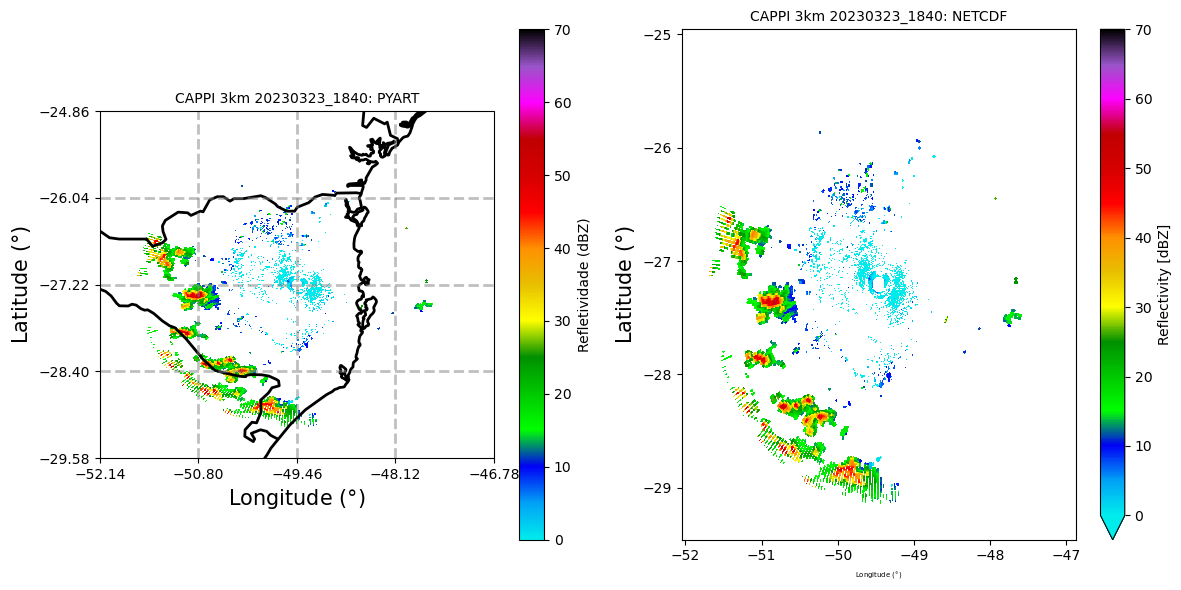

In [6]:
"""
%%time
#========================================================================================================================#
#                                              IMPORTAÇÃO DAS BIBLIOTECAS
#========================================================================================================================#
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pyart
import pandas as pd
import numpy as np
import glob
from datetime import datetime
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

#========================================================================================================================#
#                                                 DIRETÓRIOS
#========================================================================================================================#
dir_input = 'input/2023-03-23/'
dir_output = 'output/05_NETCDF_CAPPI/'

#========================================================================================================================#
#                                                 LISTA DOS ARQUIVOS
#========================================================================================================================#
files = ['input/2023-03-23/R13227490_202303231840.hdf']

#========================================================================================================================#
#                                                 PROCESSAMENTO
#========================================================================================================================#
for file in files:

    print('PROCESSANDO ===>>', file)

    #--------------------------------------------------------------#
    #                     LEITURA DO DADO
    #--------------------------------------------------------------#
    # leitura do arquivo
    radar = pyart.aux_io.read_odim_h5(f'{file}')   
    
    # extrai a data e horário do radar
    ano = str(pyart.util.datetime_from_grid(radar).year)
    mes = str(pyart.util.datetime_from_grid(radar).month).zfill(2)
    dia = str(pyart.util.datetime_from_grid(radar).day).zfill(2)
    hor = str(pyart.util.datetime_from_grid(radar).hour).zfill(2)
    min = str(pyart.util.datetime_from_grid(radar).minute).zfill(2)
    seg = str(pyart.util.datetime_from_grid(radar).second).zfill(2)

    # extrai a latitude, longitude e altitude do radar
    lat_radar, lon_radar = radar.latitude['data'][0], radar.longitude['data'][0]
    altitude = radar.altitude['data'][0]
    print('...... 1. Extraiu informações da data')

    #--------------------------------------------------------------#
    #                  FORÇANDO A FREQUÊNCIA
    #--------------------------------------------------------------#
    # No dado não esta vindo o valor da frequência do radar banda-S. 
    # Assim definimos a frequência manualmente
    radar.instrument_parameters = {'frequency': {'data': [2.8e9]}}
            
    #--------------------------------------------------------------#
    #                  CALCULA PRECIPITAÇÃO
    #--------------------------------------------------------------#
    # a) Z-R
    chuva_z = pyart.retrieve.est_rain_rate_z(radar, refl_field='reflectivity_horizontal')

    # b) KDP-R
    chuva_kdp = pyart.retrieve.est_rain_rate_kdp(radar, kdp_field='specific_differential_phase')

    # c) Z-R e KDP-R
    chuva_z_kdp = pyart.retrieve.est_rain_rate_zkdp(radar, refl_field='reflectivity_horizontal', kdp_field='specific_differential_phase', thresh_max=True, thresh=40)

    # adiciona os campos criados na estrutura do objeto "radar"
    radar.add_field('rainrate_z', chuva_z)
    radar.add_field('rainrate_kdp', chuva_kdp)
    radar.add_field('rainrate_z_kdp', chuva_z_kdp)

    # d) Z-ZDR-KDP
    # guarda os campos de cada variável
    refl = radar.fields['reflectivity_horizontal']['data']
    zdr = radar.fields['differential_reflectivity']['data']
    kdp = radar.fields['specific_differential_phase']['data']
    
    # chuva usando somente KDP
    rkdp = 44.0 * np.ma.power(abs(kdp), 0.822)
    
    # Marshall Palmer para Z-R
    z = np.ma.power(10.0, refl/10)
    r_zr = (np.ma.power(z/200, 1/1.6))
    
    # copia o campo r_zr como matriz de saida
    rain = r_zr
    
    # agora verifica os limiares para uso com Z-ZDR-KDP
    idx = np.where(r_zr <= 6)
    rain[idx] = r_zr[idx] / (0.4 + 5.0 * np.ma.power(abs(zdr[idx] - 1), 1.3))
    
    idx = np.where(r_zr > 6)
    rain[idx] = rkdp[idx] / (0.4 + 3.5 * np.ma.power(abs(zdr[idx] - 1), 1.7))
    
    idx = np.where(r_zr > 50)
    rain[idx] = rkdp[idx]
    
    # adiciona o campo de precipitação
    radar.add_field_like('reflectivity_horizontal', 'rainrate_z_zdr_kdp', rain)
    radar.fields['rainrate_z_zdr_kdp']['units'] = 'mm/h'
    radar.fields['rainrate_z_zdr_kdp']['standard_name'] = 'Rain_Rate'
    radar.fields['rainrate_z_zdr_kdp']['long_name'] = 'Rain Rate'
    print('...... 2. Calculou campo de taxa de precipitação')
    
    #--------------------------------------------------------------#
    #                      GERA CAPPI
    #--------------------------------------------------------------#
    cappi_altitude = 3000
    if (cappi_altitude < altitude):
        print('erro: altura do cappi menor que a altitude do radar')
    cappi_altitude = cappi_altitude - altitude

    cappi = pyart.map.grid_from_radars(radar, 
                                       grid_shape=(1, 500, 500),
                                       grid_limits=((cappi_altitude, cappi_altitude,),
                                                    (-250000., 250000.),
                                                    (-250000, 250000.)),
                                       grid_origin = (lat_radar, lon_radar),
                                       
                                       roi_func='dist_beam',
                                       zdist_factor=1.4,
                                       h_factor=1.2, 
                                       nb=1.2,#nb menor parece melhor
                                       bsp=0.5, 
                                       weighting_function='barnes2',
                                       
                                       fields=['reflectivity_horizontal', 'differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio',
                                               'velocity_horizontal',
                                               'rainrate_z', 'rainrate_kdp', 'rainrate_z_kdp', 'rainrate_z_zdr_kdp'])
    print('...... 3. Gerou CAPPI')
     
    #-------------------------------------------------------#
    #           SALVA ARQUIVO NO FORMATO NETCDF
    #-------------------------------------------------------#
    # transforma para Xarray
    cappi_dataset = cappi.to_xarray() # cappi_3d = np.zeros((z_grid_points, y_grid_points, x_grid_points)) # cappi_3d[alturas, latitudes, longitudes])
    print('...... 4. Transformou para DataSet')

    # transforma o dataset para array: (time, z, y, x)
    rainrate_z_values = cappi_dataset['rainrate_z'][0,0,:,:].values
    rainrate_kdp_values = cappi_dataset['rainrate_kdp'][0,0,:,:].values
    rainrate_z_kdp_values = cappi_dataset['rainrate_z_kdp'][0,0,:,:].values
    rainrate_z_zdr_kdp_values = cappi_dataset['rainrate_z_zdr_kdp'][0,0,:,:].values
    
    dbz_values = cappi_dataset['reflectivity_horizontal'][0,0,:,:].values 
    zdr_values = cappi_dataset['differential_reflectivity'][0,0,:,:].values 
    kdp_values = cappi_dataset['specific_differential_phase'][0,0,:,:].values 
    cor_values = cappi_dataset['cross_correlation_ratio'][0,0,:,:].values 
    vel_values = cappi_dataset['velocity_horizontal'][0,0,:,:].values 

    # define encoding para compactação dos dados
    encoding = {
                'rainrate_z': {'zlib': True},
                'rainrate_kdp': {'zlib': True},
                'rainrate_z_kdp': {'zlib': True},
                'rainrate_z_zdr_kdp': {'zlib': True},
                
                'reflectivity_horizontal': {'zlib': True},
                'differential_reflectivity': {'zlib': True},
                'specific_differential_phase': {'zlib': True},
                'cross_correlation_ratio': {'zlib': True},
                'velocity_horizontal': {'zlib': True}
               }

    # define as variáveis
    data_vars = {
                 'rainrate_z': (('lat', 'lon'), rainrate_z_values, {'units': 'mm/h', 'long_name': 'Taxa de Precipitação', '_FillValue': 0}),  
                 'rainrate_kdp': (('lat', 'lon'), rainrate_kdp_values, {'units': 'mm/h', 'long_name': 'Taxa de Precipitação', '_FillValue': 0}),  
                 'rainrate_z_kdp': (('lat', 'lon'), rainrate_z_kdp_values, {'units': 'mm/h', 'long_name': 'Taxa de Precipitação', '_FillValue': 0}),  
                 'rainrate_z_zdr_kdp': (('lat', 'lon'), rainrate_z_zdr_kdp_values, {'units': 'mm/h', 'long_name': 'Taxa de Precipitação', '_FillValue': 0}),  
                 
                 'reflectivity_horizontal': (('lat', 'lon'), dbz_values, {'units': 'dBZ', 'long_name': 'Reflectivity', '_FillValue': 0}),
                 'differential_reflectivity': (('lat', 'lon'), zdr_values, {'units': 'dB', 'long_name': 'Differential Reflectivity', '_FillValue': 0}),
                 'specific_differential_phase': (('lat', 'lon'), kdp_values, {'units': 'degree/km', 'long_name': 'Specific Differential Phase', '_FillValue': 0}),
                 'cross_correlation_ratio': (('lat', 'lon'), cor_values, {'units': '#', 'long_name': 'Cross Correlation Ratio', '_FillValue': 0}),
                 'velocity_horizontal': (('lat', 'lon'), vel_values, {'units': 'm/s', 'long_name': 'Corrected Velocity', '_FillValue': 0})        
                }
  
    # coordenadas 
    #coords = {'time': cappi_dataset['time'].values, 'alt': cappi_dataset['z'].values + altitude, 'lat': cappi_dataset['lat'][:,0].values, 'lon': cappi_dataset['lon'][:,0].values}
    coords = {'lat': cappi_dataset['lat'][:,0].values, 'lon': cappi_dataset['lon'][0,:].values}
    
    # atributos  
    attrs = {'description': 'Constant Altitude Plan Position Indicator (CAPPI) de 3km de altitude com resolução espacial horizontal de 1 km para o radar de LONTRAS (SC)',                             
             'creation_data': str(datetime.now()), 
             'author':'Enrique V. Mattos',
             'email': 'enrique@unifei.edu.br'}

    # gera Dataset
    dataset = xr.Dataset(data_vars = data_vars, coords = coords, attrs = attrs)

    # salva arquivo netcdf
    dataset.to_netcdf(f'{dir_output}teste_cappi_3000m_lontras_{ano}{mes}{dia}_{hor}{min}{seg}.nc',  encoding=encoding)
    print('...... 5. Salvou arquivo NETCDF')

    #--------------------------------------------------------------#
    #                   PLOTA QUICKLOOK DO CAPPI
    #--------------------------------------------------------------#
    #cappi
    netcdf = xr.open_dataset(f'{dir_output}teste_cappi_3000m_lontras_{ano}{mes}{dia}_{hor}{min}{seg}.nc')

    # importa bibliotecas
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs  

    # define o tamanho da figura
    fig = plt.figure(figsize=(12,6))

    #------------------------------------------#
    #        CAPPI DIRETO DO PYART
    #------------------------------------------#
    ax1 = plt.subplot(121, projection=ccrs.PlateCarree())

    # monta um objeto "display" do Py-ART
    display = pyart.graph.GridMapDisplay(cappi)

    # corrige o nivel do cappi levando em conta a altitude do radar
    display.grid.z['data'] = display.grid.z['data'] + altitude

    # plota o cappi
    display.plot_grid("reflectivity_horizontal",
                      level=0,
                      vmin=0,
                      vmax=70,
                      ax=ax1,
                      cmap='pyart_NWSRef',
                      colorbar_label='Refletividade (dBZ)')

    # plota os aneis de distância do radar
    #evm_plota_aneis_em_geral([100, 250], lon_radar, lat_radar, 'black', label='Radar: 45 km')

    # título da figura
    plt.title(f'CAPPI 3km {ano}{mes}{dia}_{hor}{min}: PYART', fontsize=10)

    # nome dos eixos x e y
    ax1.set_xlabel('Longitude ($\degree$)', fontsize=15)
    ax1.set_ylabel('Latitude ($\degree$)', fontsize=15)

    #------------------------------------------#
    #        CAPPI DO NETCDF
    #------------------------------------------#
    #ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
    ax2 = plt.subplot(122)
    
    # mapa
    netcdf['reflectivity_horizontal'][:,:].plot(cmap='pyart_NWSRef', vmin=0, vmax=70, ax=ax2)

    # título 
    plt.title(f'CAPPI 3km {ano}{mes}{dia}_{hor}{min}: NETCDF', fontsize=10)

    # nome dos eixos x e y
    ax2.set_xlabel('Longitude ($\degree$)', fontsize=5)
    ax2.set_ylabel('Latitude ($\degree$)', fontsize=15)

    # recorta figura
    plt.tight_layout()

    # salva figura
    plt.savefig(f'{dir_output}comparacao_lontras_cappi_plotpyart_e_plotnetcdf', dpi=300)
"""